## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # For SMOTE with CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import joblib

## Load Data

In [3]:
# Load data
df = pd.read_csv("Coronary Artery Disease.csv")

## Data Inspection

In [4]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())
# Checking for duplicates 
print(f'There are {df.duplicated().sum()} duplicates in the dataset')

Missing values:
 Age                      0
Weight                   0
Length                   0
Sex                      0
BMI                      0
DM                       0
HTN                      0
Current Smoker           0
EX-Smoker                0
FH                       0
Obesity                  0
CRF                      0
CVA                      0
Airway disease           0
Thyroid Disease          0
CHF                      0
DLP                      0
BP                       0
PR                       0
Edema                    0
Weak Peripheral Pulse    0
Lung rales               0
Systolic Murmur          0
Diastolic Murmur         0
Typical Chest Pain       0
Dyspnea                  0
Function Class           0
Atypical                 0
Nonanginal               0
Exertional CP            0
LowTH Ang                0
Q Wave                   0
St Elevation             0
St Depression            0
Tinversion               0
LVH                      0
Poor R Prog

In [5]:
print("\nData shape:", df.shape)
print("\nSample data:\n", df.head())


Data shape: (303, 56)

Sample data:
    Age  Weight  Length    Sex        BMI  DM  HTN  Current Smoker  EX-Smoker  \
0   53      90     175   Male  29.387755   0    1               1          0   
1   67      70     157  Fmale  28.398718   0    1               0          0   
2   54      54     164   Male  20.077335   0    0               1          0   
3   66      67     158  Fmale  26.838648   0    1               0          0   
4   50      87     153  Fmale  37.165193   0    1               0          0   

   FH  ...    K   Na    WBC Lymph Neut  PLT EF-TTE  Region RWMA     VHD  \
0   0  ...  4.7  141   5700    39   52  261     50            0       N   
1   0  ...  4.7  156   7700    38   55  165     40            4       N   
2   0  ...  4.7  139   7400    38   60  230     40            2    mild   
3   0  ...  4.4  142  13000    18   72  742     55            0  Severe   
4   0  ...  4.0  140   9200    55   39  274     50            0  Severe   

     Cath  
0     Cad  
1     

Distribution of CAD Patients

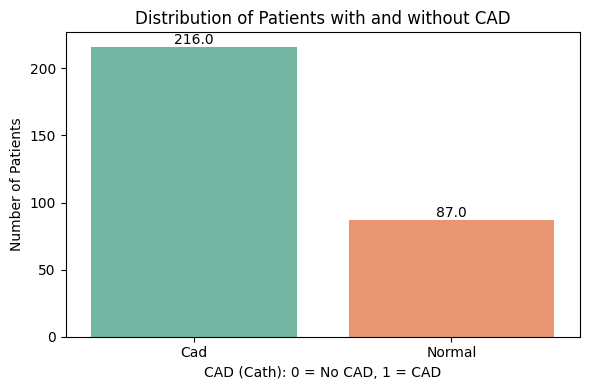

CAD Class Distribution (%):
 Cath
Cad       71.287129
Normal    28.712871
Name: proportion, dtype: float64


In [6]:
# Plot with updated syntax
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='Cath', hue='Cath', palette='Set2', legend=False)
plt.title("Distribution of Patients with and without CAD")
plt.xlabel("CAD (Cath): 0 = No CAD, 1 = CAD")
plt.ylabel("Number of Patients")

# Add counts on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Show class percentages
cad_counts = df['Cath'].value_counts(normalize=True) * 100
print("CAD Class Distribution (%):\n", cad_counts)


Visualization of Demographic Factors and Their Relationship with Coronary Artery Disease (CAD) Diagnosis

In [ ]:
#Boxplots for continuous variables (Age, Weight, BMI) display distribution differences by CAD presence
#The red dashed line on the BMI plot marks the obesity cutoff (BMI 30).
#Countplots for categorical variables (Sex and Diabetes) show group sizes and CAD presence proportionally.

plt.figure(figsize=(18, 12))

# 1. Age distribution by CAD diagnosis
plt.subplot(2, 3, 1)
sns.boxplot(data=df, x='Cath', y='Age')
plt.title('Age by CAD Diagnosis')
plt.xlabel('CAD Diagnosis (Cath)')
plt.ylabel('Age (years)')

# 2. Weight distribution by CAD diagnosis
plt.subplot(2, 3, 2)
sns.boxplot(data=df, x='Cath', y='Weight')
plt.title('Weight by CAD Diagnosis')
plt.xlabel('CAD Diagnosis (Cath)')
plt.ylabel('Weight (kg)')

# 3. BMI distribution by CAD diagnosis
plt.subplot(2, 3, 3)
sns.boxplot(data=df, x='Cath', y='BMI')
plt.axhline(30, color='r', linestyle='--', label='Obesity BMI Threshold (30)')
plt.title('BMI by CAD Diagnosis')
plt.xlabel('CAD Diagnosis (Cath)')
plt.ylabel('BMI (kg/m²)')
plt.legend()

# 4. Sex distribution by CAD diagnosis (count plot)
plt.subplot(2, 3, 4)
sns.countplot(data=df, x='Sex', hue='Cath')
plt.title('Sex Distribution by CAD Diagnosis')
plt.xlabel('Sex (0=Female, 1=Male)')
plt.ylabel('Count')
plt.legend(title='CAD Diagnosis (Cath)', labels=['No CAD', 'CAD'])

# 5. Diabetes prevalence by CAD diagnosis (count plot)
plt.subplot(2, 3, 5)
sns.countplot(data=df, x='DM', hue='Cath')
plt.title('Diabetes Status by CAD Diagnosis')
plt.xlabel('Diabetes (0=No, 1=Yes)')
plt.ylabel('Count')
plt.legend(title='CAD Diagnosis (Cath)', labels=['No CAD', 'CAD'])

plt.tight_layout()
plt.show()

Blood-Related and Lipid Profile Distributions by CAD Diagnosis

In [ ]:
# This section explores the relationship between various blood-related indicators and the presence of Coronary Artery Disease (CAD), based on the Cath diagnosis. Box plots are used to compare the distribution of each feature between individuals diagnosed with CAD and those not diagnosed.
plt.figure(figsize=(15, 16))

# 1. Blood Pressure distribution by CAD diagnosis
plt.subplot(4, 2, 1)
sns.boxplot(data=df, x='Cath', y='BP')
plt.title('Blood Pressure by CAD Diagnosis')
plt.xlabel('CAD Diagnosis (Cath)')
plt.ylabel('Blood Pressure (mmHg)')

# 2. WBC count distribution by CAD diagnosis
plt.subplot(4, 2, 2)
sns.boxplot(data=df, x='Cath', y='WBC')
plt.axhline(11000, color='r', linestyle='--', label='Upper Normal Limit (11,000)')
plt.title('White Blood Cell Count by CAD Diagnosis')
plt.xlabel('CAD Diagnosis (Cath)')
plt.ylabel('WBC count (cells/microliter)')
plt.legend()

# 3. Pulse Rate distribution by CAD diagnosis
plt.subplot(4, 2, 3)
sns.boxplot(data=df, x='Cath', y='PR')
plt.title('Pulse Rate by CAD Diagnosis')
plt.xlabel('CAD Diagnosis (Cath)')
plt.ylabel('Pulse Rate (beats per minute)')

# 4. LDL cholesterol distribution by CAD diagnosis
plt.subplot(4, 2, 4)
sns.boxplot(data=df, x='Cath', y='LDL')
plt.axhline(100, color='r', linestyle='--', label='LDL Goal (100 mg/dL)')
plt.title('LDL Cholesterol by CAD Diagnosis')
plt.xlabel('CAD Diagnosis (Cath)')
plt.ylabel('LDL (mg/dL)')
plt.legend()

# 5. HDL cholesterol distribution by CAD diagnosis
plt.subplot(4, 2, 5)
sns.boxplot(data=df, x='Cath', y='HDL')
plt.axhline(60, color='g', linestyle='--', label='HDL Protective Level (60 mg/dL)')
plt.title('HDL Cholesterol by CAD Diagnosis')
plt.xlabel('CAD Diagnosis (Cath)')
plt.ylabel('HDL (mg/dL)')
plt.legend()

# 6. Triglycerides distribution by CAD diagnosis
plt.subplot(4, 2, 6)
sns.boxplot(data=df, x='Cath', y='TG')
plt.title('Triglycerides by CAD Diagnosis')
plt.xlabel('CAD Diagnosis (Cath)')
plt.ylabel('Triglycerides (mg/dL)')

# 7. ESR distribution by CAD diagnosis
plt.subplot(4, 2, 7)
sns.boxplot(data=df, x='Cath', y='ESR')
plt.axhline(25, color='r', linestyle='--', label='Upper Normal ESR (25)')
plt.title('Erythrocyte Sedimentation Rate (ESR) by CAD Diagnosis')
plt.xlabel('CAD Diagnosis (Cath)')
plt.ylabel('ESR (mm/hr)')
plt.legend()

plt.tight_layout()
plt.show()

## Data Preprocessing

In [ ]:
# Label encoding for categorical variables
categorical_cols = ['Sex', 'Obesity', 'Current Smoker', 'EX-Smoker', 'FH', 'CRF', 'CVA', 
                    'Airway disease', 'Thyroid Disease', 'CHF', 'DLP', 'Weak Peripheral Pulse', 
                    'Lung rales', 'Systolic Murmur', 'Diastolic Murmur', 'Typical Chest Pain', 
                    'Dyspnea', 'Atypical', 'Nonanginal', 'Exertional CP', 'LowTH Ang', 
                    'Q Wave', 'St Elevation', 'St Depression', 'Tinversion', 'LVH', 
                    'Poor R Progression', 'BBB', 'Region RWMA', 'VHD', 'Cath']

for col in categorical_cols:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Drop rows with missing target
df = df[df['Cath'].notnull()]

In [ ]:
# Remove duplicate rows
df = df.drop_duplicates()

In [ ]:
# Number of plots per row
n_cols = 4
n_rows = -(-len(categorical_cols) // n_cols)  # Ceiling division

# Set figure size
plt.figure(figsize=(20, n_rows * 4))

# Generate count plots for each categorical feature by 'Cath'
for idx, col in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.countplot(data=df, x=col, hue='Cath', palette='Set2')
    plt.title(col)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.suptitle('Categorical Feature Distributions by CAD Diagnosis', fontsize=20, y=1.02)
plt.show()

In [ ]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Correlation with target variable 'Cath'
cad_corr = correlation_matrix['Cath'].drop('Cath').sort_values(key=abs, ascending=False)

# Prepare DataFrame for plotting with hue
cad_corr_df = cad_corr.reset_index()
cad_corr_df.columns = ['Feature', 'Correlation']
cad_corr_df['hue'] = cad_corr_df['Correlation']  # use correlation as hue

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(data=cad_corr_df, x='Correlation', y='Feature', hue='hue',
            palette='coolwarm', dodge=False, legend=False)
plt.title('Correlation of Features with Coronary Artery Disease (Cath)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Feature/Target Split

In [ ]:
# Define features and target
X = df.drop(['Cath'], axis=1)
y = df['Cath']

## Feature Scaling

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Train-Test Split 

In [ ]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

## Handle Class Imbalance (SMOTE)

In [ ]:
# Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

## Model Training

In [ ]:
# Define models to compare
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

## Model Evaluation

In [ ]:
for name, model in models.items():
    # Train
    model.fit(X_train_res, y_train_res)
    
    # Predict & predict probabilities (needed for ROC AUC)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:  # Some classifiers (like SVM) may not have predict_proba
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # normalize
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {
        "accuracy": acc,
        "roc_auc": roc_auc,
        "classification_report": report,
        "confusion_matrix": cm,
        "model": model
    }
    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(cm)
    print("\n")

## Visualization - ROC Curve

In [ ]:
# Plot ROC Curves for all models
plt.figure(figsize=(8, 6))
for name, res in results.items():
    y_proba = res["model"].predict_proba(X_test)[:, 1] if hasattr(res["model"], "predict_proba") else None
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {res['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

## Model Performance Summary

In [ ]:
# Summary Table
summary = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [v['accuracy'] for v in results.values()],
    'ROC AUC': [v['roc_auc'] for v in results.values()]
}).sort_values(by='ROC AUC', ascending=False)

print("Model Performance Summary:\n", summary)

Based on the evaluation metrics, the Random Forest model demonstrated the best overall performance. Although Gradient Boosting achieved the highest accuracy, Random Forest had the highest ROC AUC score, which is crucial for medical diagnosis as it reflects the model’s ability to distinguish between patients with and without coronary artery disease. Therefore, Random Forest is considered the most effective model in this analysis.

## Hyperparameters for Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)


In [ ]:
# Evaluate best model on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting (Tuned)')
plt.legend()
plt.show()

## Save Model and Scaler

In [ ]:
# Save the best model (Random Forest)
joblib.dump(best_model, "CAD_Predictor_RF_BestModel.pkl")

# Save the scaler used on features
joblib.dump(scaler, "scaler_CAD.pkl")

Creating SHAP Explainer and Plotting Feature Importance for Coronary Artery Disease Prediction Model

In [ ]:
full_feature_names = df.drop(columns=['Cath']).columns.tolist() 

# Now convert numpy array to DataFrame with full feature names
X_train_df = pd.DataFrame(X_train, columns=full_feature_names)

# Use DataFrame with SHAP explainer
explainer = shap.Explainer(model, X_train_df)
shap_values = explainer(X_train_df)

#Displays the impact of all features on the model’s output across the dataset. Each point represents a patient, showing how the feature value (color) affects the prediction. Features are ranked by their overall importance.
shap.summary_plot(shap_values, X_train_df)
#Shows the average absolute SHAP value for each feature, indicating the overall influence of each feature on model predictions.
shap.plots.bar(shap_values)
